In [ ]:
pip install config

In [ ]:
import requests
import config
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from openpyxl import load_workbook

In [ ]:
response = requests.get('https://timesofindia.indiatimes.com/briefs')

In [ ]:
soup=BeautifulSoup(response.content,'html.parser')
cards = soup.find_all('div', class_='brief_box')  # Replace 'card-class' with the actual class name of the cards


In [ ]:
existing_file = '/content/drive/MyDrive/sentimental_analysis/existing_bliank_file.xlsx'
wb = load_workbook(existing_file)
print(wb)

In [ ]:
ws = wb.active


In [ ]:
i=0
for card in cards:
    headline = card.find('h2')  # Replace with actual tag/class if different

    if headline:
        headline_text = headline.get_text(strip=True)
    else:
        continue

        # Extract Description (assuming it's in a <p> tag)
    description = card.find('p')  # Replace with actual tag/class if different
    description_text = description.get_text(strip=True) if description else "No description found"

        # Extract Span Element (assuming it's a <span> with a specific class)
    span = card.find('span', class_='subsection_card')  # Replace 'span-class' with the actual class name
    span_text = span.get_text(strip=True) if span else "No span found"

        # Print the extracted values
    # print(f"Headline: {headline_text}")
    # print(f"Description: {description_text}")
    # print(f"Span: {span_text}")
    new_data = [[i,headline_text,description_text,span_text]]
    i=i+1
    for row in new_data:
        ws.append(row)
    wb.save(existing_file)

In [ ]:
import pandas as pd

# Define the path to the Excel file and the output CSV file
xlsx_file = '/content/drive/MyDrive/sentimental_analysis/existing_bliank_file.xlsx'  # Replace with your Excel file path
csv_file = '/content/drive/MyDrive/sentimental_analysis/webscrap_fake_real_final.csv'   # Replace with your desired CSV file path

# Read the Excel file
df = pd.read_excel(xlsx_file)

# Convert the DataFrame to a CSV file
df.to_csv(csv_file, index=False)

print(f"Conversion complete: '{xlsx_file}' has been converted to '{csv_file}'")

Conversion complete: '/content/drive/MyDrive/sentimental_analysis/existing_bliank_file.xlsx' has been converted to '/content/drive/MyDrive/sentimental_analysis/webscrap_fake_real_final.csv'


In [ ]:
pip install transformers pandas torch scikit-learn


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/sentimental_analysis/webscrap_fake_real_final.csv")

# Display the first few rows of the dataset
print(df.head())

   Index                                              Title  \
0      0  Era of uninterrupted talks with Pakistan over:...   
1      1  'Factually incorrect ... ': Centre hits back a...   
2      2  Fill vacancy with a woman judge, retiring Just...   
3      3  MCG staffer thrashed over 'affair with scrap v...   
4      4  Ta-ta Vistara! Merger with Air India set for N...   

                                         Description Area of news  
0  India has received an invitation for PM Modi t...        India  
1  Union Minister Annapurna Devi responded to CM ...        India  
2  Justice Hima Kohli, the eighth woman to become...        India  
3  In Gurgaon, a sanitation supervisor named Nare...         City  
4  Vistara will merge into Air India on November ...     Business  


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the first model and tokenizer (e.g., BERT)
bert_model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name)

# Load the second model and tokenizer (e.g., RoBERTa)
roberta_model_name = "roberta-base"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

def predict_fake_news(text):
    # Tokenize and predict with BERT
    bert_inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        bert_outputs = bert_model(**bert_inputs)
    bert_logits = bert_outputs.logits
    bert_probs = torch.softmax(bert_logits, dim=1).squeeze().tolist()

    # Tokenize and predict with RoBERTa
    roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        roberta_outputs = roberta_model(**roberta_inputs)
    roberta_logits = roberta_outputs.logits
    roberta_probs = torch.softmax(roberta_logits, dim=1).squeeze().tolist()

    # Average the probabilities from both models
    avg_probs = [(b + r) / 2 for b, r in zip(bert_probs, roberta_probs)]

    # Extracting the class with the highest average probability
    predicted_class = torch.argmax(torch.tensor(avg_probs)).item()

    labels = ["Real", "Fake"]
    return labels[predicted_class], avg_probs


In [ ]:
# Create empty lists to hold the results
predictions = []
real_probs = []
fake_probs = []

# Loop through each description and predict using the ensemble model
for description in df['Description']:
    prediction, probs = predict_fake_news(description)
    predictions.append(prediction)
    real_probs.append(probs[0])
    fake_probs.append(probs[1])

# Add the results to the DataFrame
df['Prediction'] = predictions
df['Real_Prob'] = real_probs
df['Fake_Prob'] = fake_probs


In [ ]:
# Save the dataframe with predictions to a new CSV file
df.to_csv("/content/drive/MyDrive/sentimental_analysis/fake_or_real_webscrap_mergemodel.csv", index=False)

# Display the first few rows of the updated dataframe
print(df.head())

   Index                                              Title  \
0      0  Era of uninterrupted talks with Pakistan over:...   
1      1  'Factually incorrect ... ': Centre hits back a...   
2      2  Fill vacancy with a woman judge, retiring Just...   
3      3  MCG staffer thrashed over 'affair with scrap v...   
4      4  Ta-ta Vistara! Merger with Air India set for N...   

                                         Description Area of news Prediction  \
0  India has received an invitation for PM Modi t...        India       Fake   
1  Union Minister Annapurna Devi responded to CM ...        India       Fake   
2  Justice Hima Kohli, the eighth woman to become...        India       Real   
3  In Gurgaon, a sanitation supervisor named Nare...         City       Real   
4  Vistara will merge into Air India on November ...     Business       Fake   

   Real_Prob  Fake_Prob  
0   0.487625   0.512375  
1   0.496709   0.503291  
2   0.507640   0.492360  
3   0.514481   0.485519  
4   0.4649

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# Combine the real and fake probabilities into a single feature for clustering
features = np.array(list(zip(df['Real_Prob'], df['Fake_Prob'])))

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=5)
df['Cluster'] = dbscan.fit_predict(features)

# Save the results with clusters to a new CSV file
df.to_csv("/content/drive/MyDrive/sentimental_analysis/fake_or_real_webscrap_mergemodel.csv", index=False)

# Display the first few rows of the updated dataframe
print(df.head())


   Index                                              Title  \
0      0  Era of uninterrupted talks with Pakistan over:...   
1      1  'Factually incorrect ... ': Centre hits back a...   
2      2  Fill vacancy with a woman judge, retiring Just...   
3      3  MCG staffer thrashed over 'affair with scrap v...   
4      4  Ta-ta Vistara! Merger with Air India set for N...   

                                         Description Area of news Prediction  \
0  India has received an invitation for PM Modi t...        India       Fake   
1  Union Minister Annapurna Devi responded to CM ...        India       Fake   
2  Justice Hima Kohli, the eighth woman to become...        India       Real   
3  In Gurgaon, a sanitation supervisor named Nare...         City       Real   
4  Vistara will merge into Air India on November ...     Business       Fake   

   Real_Prob  Fake_Prob  Cluster  
0   0.487625   0.512375        0  
1   0.496709   0.503291        0  
2   0.507640   0.492360        0  


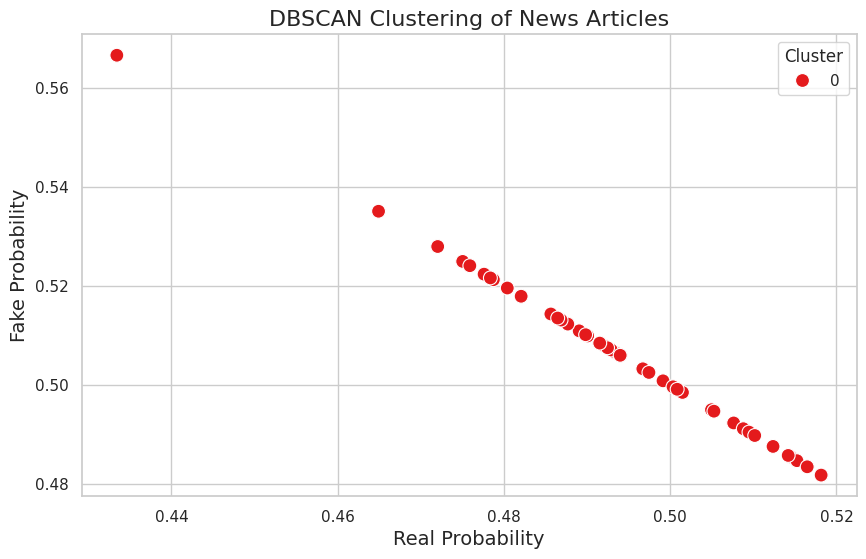

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the style for the plot
sns.set(style="whitegrid")

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Real_Prob',
    y='Fake_Prob',
    hue='Cluster',
    palette='Set1',
    data=df,
    legend='full',
    s=100  # Size of points
)

# Set plot title and labels
plt.title('DBSCAN Clustering of News Articles', fontsize=16)
plt.xlabel('Real Probability', fontsize=14)
plt.ylabel('Fake Probability', fontsize=14)

# Show the plot
plt.show()


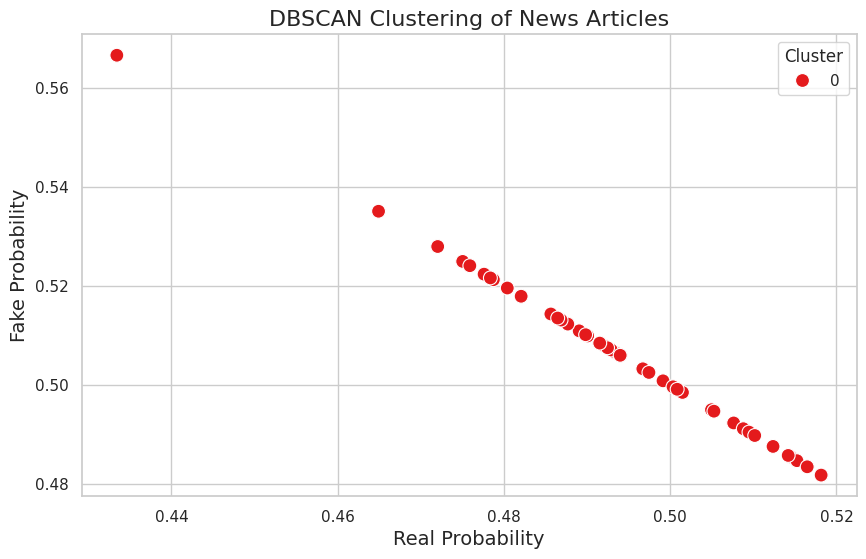

In [ ]:
# Save the plot as a PNG image
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Real_Prob',
    y='Fake_Prob',
    hue='Cluster',
    palette='Set1',
    data=df,
    legend='full',
    s=100
)

plt.title('DBSCAN Clustering of News Articles', fontsize=16)
plt.xlabel('Real Probability', fontsize=14)
plt.ylabel('Fake Probability', fontsize=14)

plt.savefig('/content/drive/MyDrive/sentimental_analysis/cluster_plot.png')
plt.show()